# Import necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Reading data

In [3]:
df =  pd.read_csv(r"./creditcard.csv")

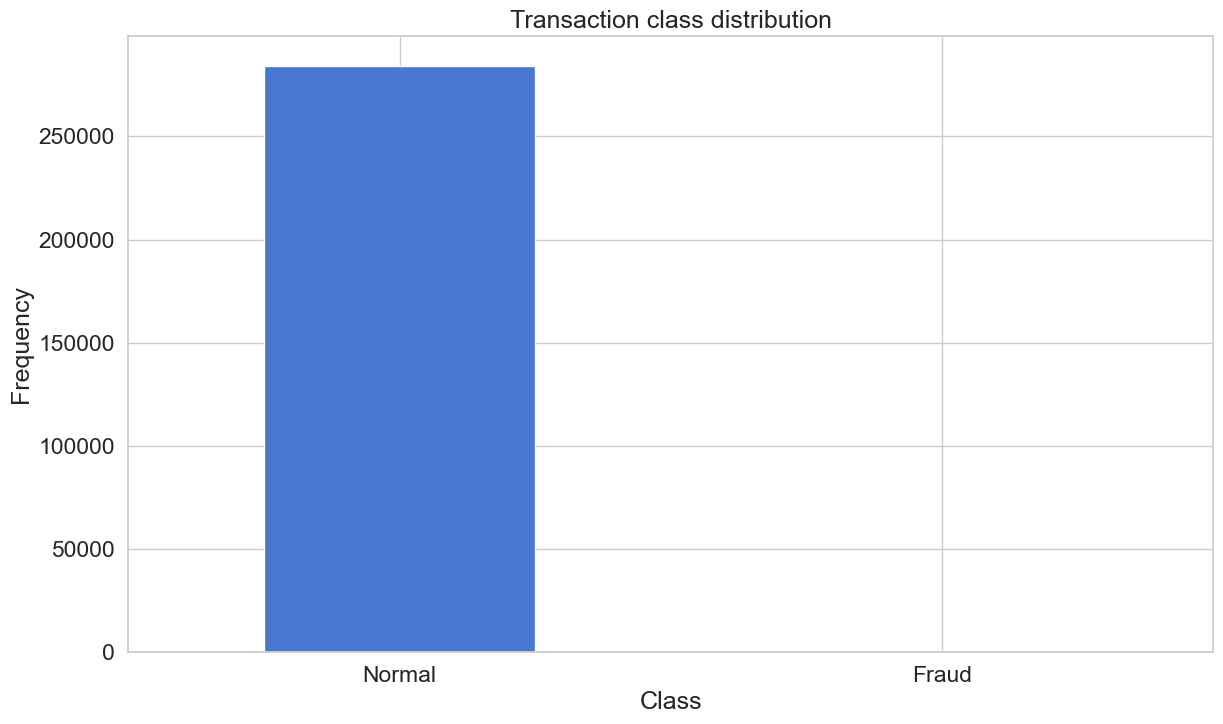

In [4]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

# Applying standard scaling

In [5]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Splitting Dataset

In [6]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [7]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [8]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [9]:
nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', 
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.keras", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/10
7108/7108 [==============================] - 9s 1ms/step - loss: 0.8046 - accuracy: 0.5758 - val_loss: 0.7807 - val_accuracy: 0.6330
Epoch 2/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7365 - accuracy: 0.6491 - val_loss: 0.7568 - val_accuracy: 0.6647
Epoch 3/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7217 - accuracy: 0.6689 - val_loss: 0.7478 - val_accuracy: 0.6758
Epoch 4/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7154 - accuracy: 0.6779 - val_loss: 0.7450 - val_accuracy: 0.6836
Epoch 5/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7115 - accuracy: 0.6894 - val_loss: 0.7420 - val_accuracy: 0.6897
Epoch 6/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7084 - accuracy: 0.6972 - val_loss: 0.7387 - val_accuracy: 0.7095
Epoch 7/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7061 - accuracy: 0.7037 - val_loss: 0.7364 - val_accuracy:

# Visualizing Data

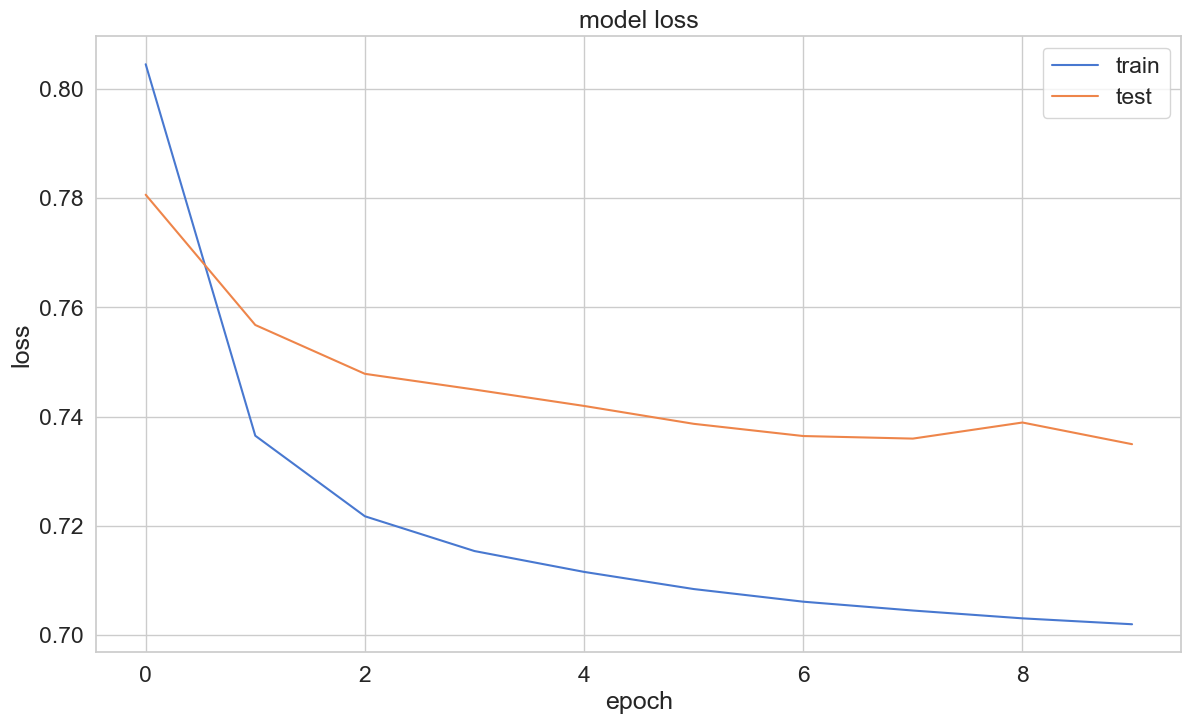

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

# Prediction

In [11]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 1s 752us/step


In [12]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

In [13]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.733983,0.001720
std,3.460529,0.041443
min,0.037362,0.000000
25%,0.240507,0.000000
50%,0.389038,0.000000
75%,0.615581,0.000000
max,264.693107,1.000000


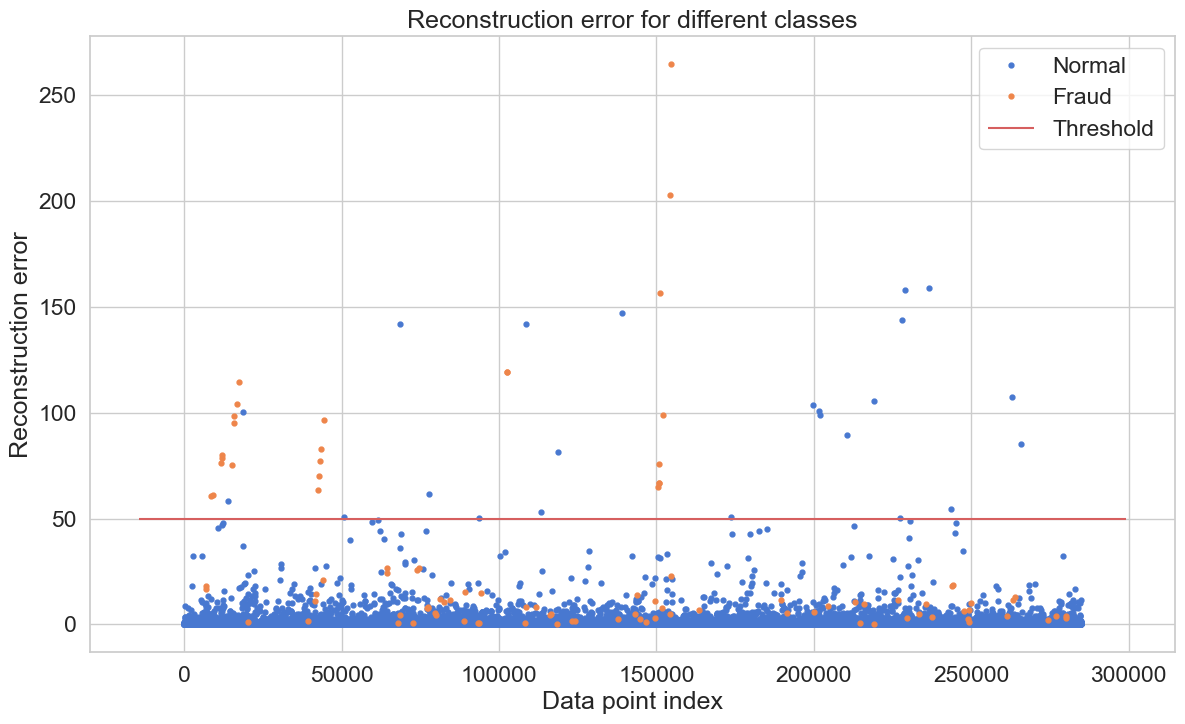

In [14]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [15]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

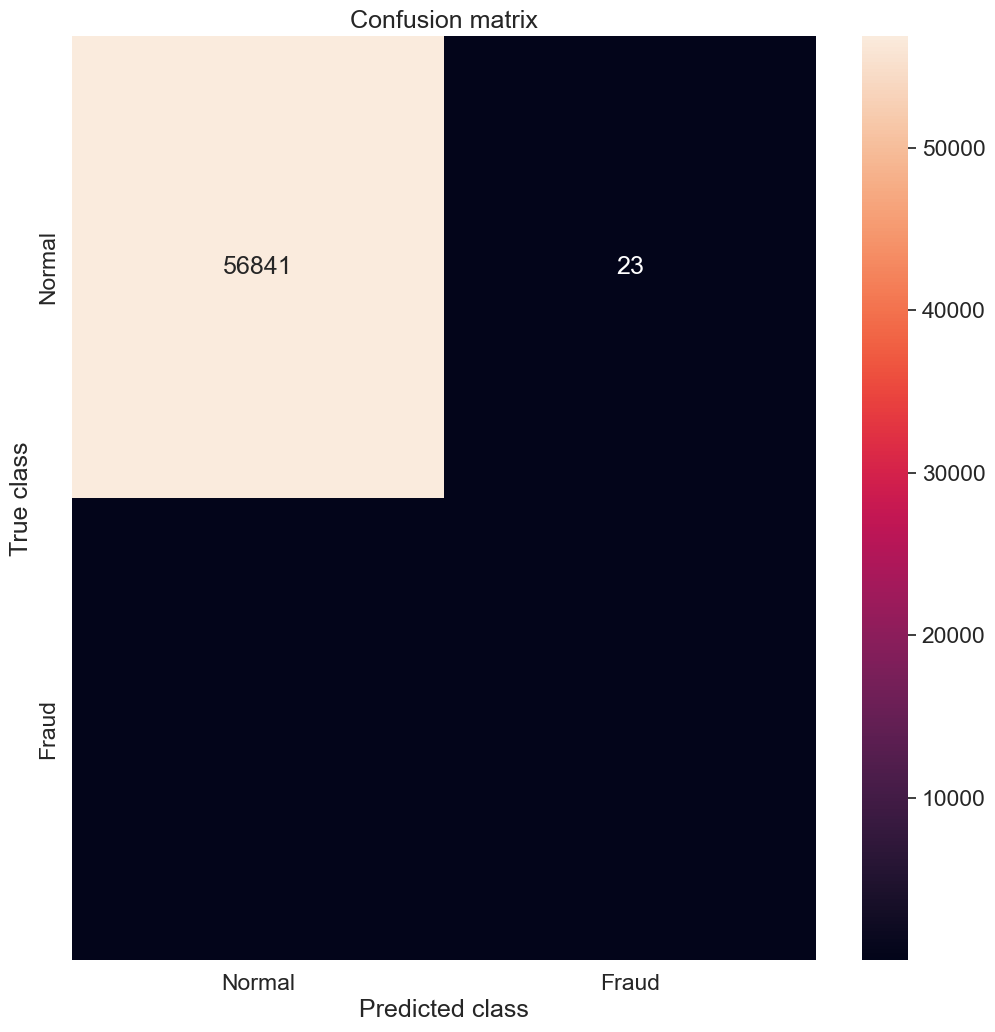

In [16]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [17]:
error_df['pred'] = y_pred

In [18]:
print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred'])) 
print("Recall:",recall_score(error_df['true_class'],error_df['pred']))
print("Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983146659176293
Recall: 0.25510204081632654
Precision: 0.5208333333333334
